In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hdf5manager import hdf5manager as h5
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import scipy
from pandas import pandas as pd
from pandas import DataFrame
from skimage.measure import label, regionprops
from scipy.ndimage.filters import gaussian_filter, convolve
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
import cv2

Error importing slackNotify.py
	 ERROR :  No module named 'slacker'


In [2]:
path = '/Users/jcrndm/Downloads/test_angs_mags.hdf5'

h = h5(path)
h.keys()
print(dir(h))

mov = h.load('mags')
angs = h.load('rot_angs')
start_stop = h.load('start_stop_index')
dfof = h.load('dfof')


print(start_stop)
print(h.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'close', 'keys', 'load', 'open', 'path', 'print', 'save', 'verbose']
(1000, 5000)
['start_stop_index', 'dfof', 'mags', 'rot_angs']


In [ ]:
# path2 = '/Users/jcrndm/Downloads/brain_data.hdf5'

# k = h5(path2)
# k.keys()
# dfof = k.load('dfof_mean')
# h.save({'dfof':dfof})

# plt.plot(dfof)

(4000, 105, 141)


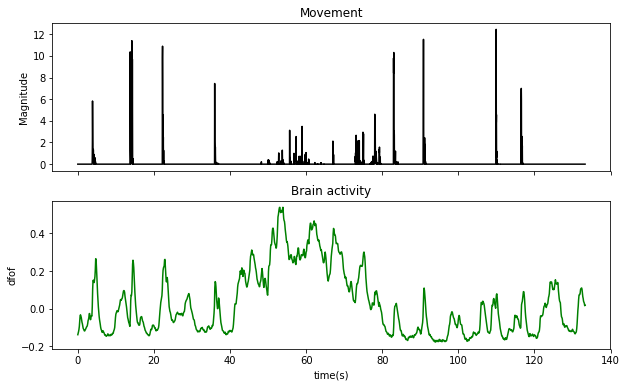

In [3]:
print(mov.shape)
mean = np.mean(mov, axis = (1,2))
fig, axis = plt.subplots(2, figsize = (10,6), sharex = True)

time = np.arange(dfof.shape[0])/10
time2 = np.arange(mean.shape[0])/30

axis[0].plot(time2, mean, color='k')
axis[0].set_ylabel('Magnitude')
axis[0].set_title ('Movement')

axis[1].plot(time, dfof, color='g')
axis[1].set_ylabel('dfof')
axis[1].set_xlabel('time(s)')
axis[1].set_title('Brain activity')

plt.savefig('/Users/jcrndm/Documents/SIP2019/Brain_Movement.png')


Text(0.5, 1.0, 'Brain activity')

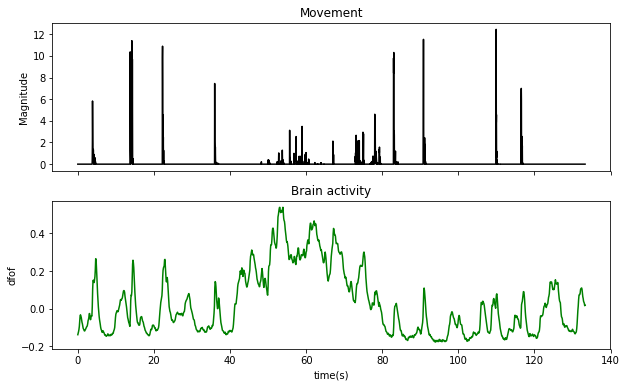

In [4]:
mean = np.mean(mov, axis = (1,2))
fig, axis = plt.subplots(2, figsize = (10,6), sharex = True)

time = np.arange(dfof.shape[0])/10
time2 = np.arange(mean.shape[0])/30

axis[0].plot(time2, mean, color='k')
axis[0].set_ylabel('Magnitude')
axis[0].set_title ('Movement')

axis[1].plot(time, dfof, color='g')
axis[1].set_ylabel('dfof')
axis[1].set_xlabel('time(s)')
axis[1].set_title('Brain activity')

<Figure size 432x288 with 0 Axes>

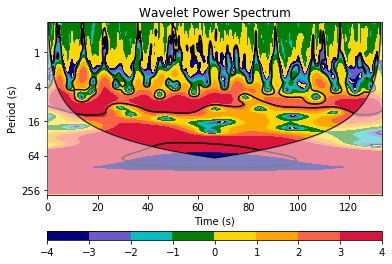

In [5]:
w = wave(dfof, fps=10)
w.plotPower()

In [ ]:
# wb.playMovie(mov)

(-0.5, 140.5, 104.5, -0.5)

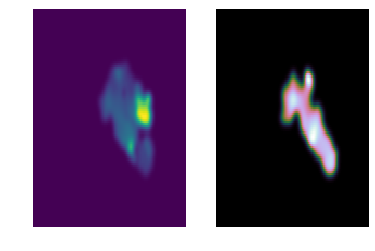

In [6]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(mov[431], aspect = "auto") 
axs[0].axis("off")
axs[1].imshow(mov[434], aspect = "auto", cmap = "cubehelix") 
axs[1].axis("off")


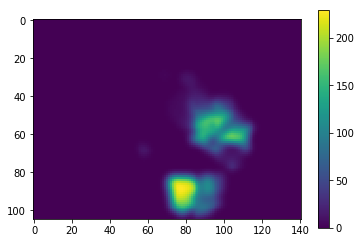

In [7]:
plt.imshow(mov[430])
plt.colorbar()

[78, 70, 102, 90, 106]
[31, 45, 51, 66, 67]
[nan, nan, nan, nan, nan, 78, 70, 102, 90, 106]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[84, 74, 95, 83]
[32, 33, 41, 45]
[0.11055127947341387, nan, nan, nan, 84, 74, 95, 83]
[0.11055127947341387, nan, nan, nan, 0.9938704214367138, nan, nan, nan]
[]
[]
[]
[]
[]
[]
[]
[]


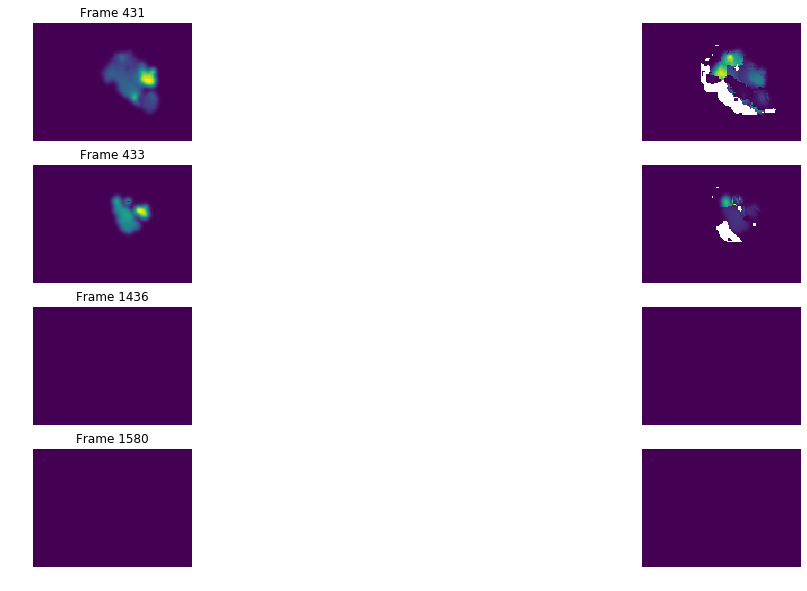

In [8]:
# Frame testing

def localMaxima2d(array_2d):
    # finds local maxima of a given 2d array
    neighborhood = np.ones((5,5))
    local_max = maximum_filter(array_2d, footprint=neighborhood)==array_2d
    background = (array_2d==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    lmax = local_max ^ eroded_background
    return lmax

frames = [431, 433, 1436, 1580]

fig, axs = plt.subplots(len(frames), 2, figsize=(20,10))
for i, frame in enumerate(frames):
    f = mov[frame]
    fmax = localMaxima2d(f)
    fmaxl = label(fmax)
    axs[i,0].set_title('Frame {}'.format(frame))
    axs[i,0].imshow(f)
    mask = f.copy() * 0
    mask[f>0]=1
    wshed = watershed(-f, fmaxl, mask=mask)
    nfmax = fmaxl.max()
    percent = f.copy()
    x = []
    y = []
    u = []
    v = []
    for region in regionprops(fmaxl):
        x.append(region.coords[0][1])
        y.append(region.coords[0][0]) 
    for region in np.arange(1,nfmax+1,1):
        regionmean = np.sum(f[wshed==region])
        percent[wshed==region]/=regionmean
        percent[wshed==region]*=angs[frame, wshed==region]
        angle = np.sum(percent[wshed==region])
        u.append(np.cos(angle))
        v.append(np.sin(angle))
    print(x)
    print(y)
    print(u+x)
    print(u+v)
    axs[i,0].quiver(x,y,u,v, angles='xy', scale_units='xy', scale = 1)
    axs[i,1].imshow(percent)
    axs[i,0].axis('off')    
    axs[i,1].axis('off')
# plt.tight_layout()
plt.show()

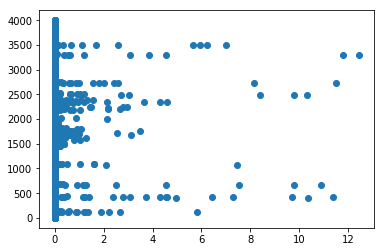

In [9]:
#  means including zeros in frame, sends to list
def findMeans(three_d_array):
    all_means = []
    for i, frame in enumerate(three_d_array):
        all_means.append(np.mean(frame))
    x = range(len(all_means))
                         
    plt.scatter(all_means, x)
    return all_means

        
mean_outputs =findMeans(mov)

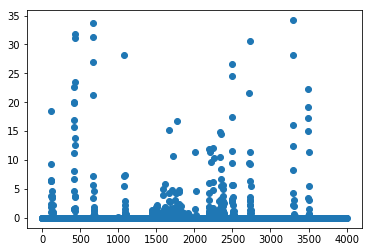

In [12]:
# standard deviation with zeros 
def standardDeviation(array_3d):
    all_deviations = []
    x = []
    for i, frame in enumerate(array_3d):
        mean = np.mean(frame)
        x.append(i)
        deviations = []
        for r in frame:
            for c in range(len(r)):
                deviations.append(((r[c]) - mean) ** 2)
        mean1 = np.mean(deviations)
        current_deviation = mean1 ** (1/2)
        all_deviations.append(current_deviation)
    plt.scatter(x, all_deviations) 
    return all_deviations
    
set_dev = standardDeviation(mov)

In [13]:
# Average magnitude in multiple dimensions
def motionCharacterize(array3d):
    brain_magnitude = np.zeros(array3d.shape[0])
    for n, frame in enumerate(array3d):
        brain_magnitude[n] = np.mean(frame)

    win_size = 10
    mag_mean = np.convolve(brain_magnitude, np.ones(win_size)/win_size, mode = 'same')

    threshold = np.zeros(mag_mean.shape)
    threshold[mag_mean > 0] = 1 
    frame_ind = np.where(threshold == 1)

    start = []
    end = []
    for i, frame in enumerate(frame_ind[0]):
        if i == 0:
            start.append(frame)
        elif len(frame_ind[0])-1 == i:   
            end.append(frame)
        elif (frame + 1) != (frame_ind[0][i + 1]):
            end.append(frame)
            start.append(frame_ind[0][i + 1])
            
#     Duration of event frames in seconds
    event_frames = (np.array(end) - np.array(start))/30
    
    mag_per_event = np.zeros(array3d.shape[0])
    for i, st in enumerate(start):
        mag_per_event[st:end[i]] = np.sum(array3d[st:end[i]])/event_frames[i]
    
#   Magnitude events
#     fig = plt.figure(figsize = (10,5))
#     plt.plot(brain_magnitude, color='k')
#     plt.plot(mag_mean,color='g')
#     plt.plot(threshold,color='r')
#     plt.ylim([0,2])
#     plt.show()
#     plt.plot(mag_per_event)
#     plt.show()
    
    return mag_per_event
mag_data = motionCharacterize(mov)

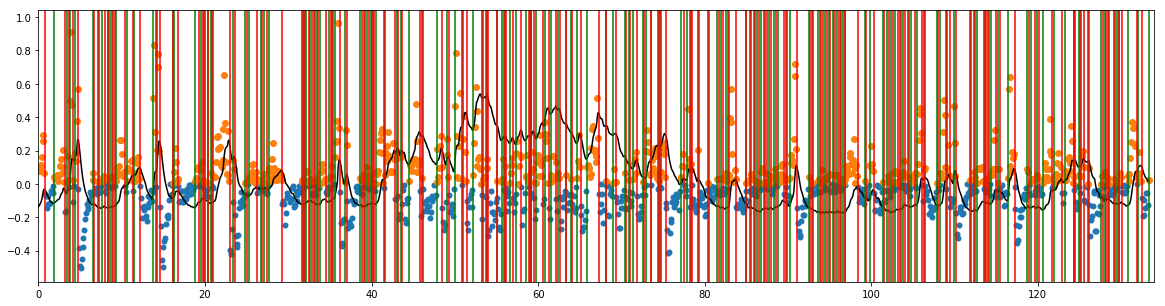

In [14]:
der = np.zeros_like(dfof)*10
# Brain Activity Boundaries
for i, val in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = val - dfof[i-1]
der *= 10

d_switch = []
u_switch = []

# Derivative of the graph by points 
for i, val in enumerate(der):
    if i == 0 or i == der.shape[0]:
        continue
    elif (val > 0) and (der[i-1] < 0):
        u_switch.append(i)
    elif (val < 0) and (der[i-1] > 0):
        d_switch.append(i)
        
u_switch = np.array(u_switch)/10
d_switch = np.array(d_switch)/10
  
time = np.arange(dfof.shape[0])/10

fig, axis = plt.subplots(1,figsize = (20,5))

# Line-Scatter Graph
plt.scatter(time[der<0], der[der<0], linewidths =0.005)
plt.scatter(time[der>0], der[der>0])
plt.plot(time, dfof, color = 'k')
for line in u_switch:
    plt.axvline(x = line, color='g')
for line in d_switch:
    plt.axvline(line, color='r')
plt.xlim([0,134])
plt.show()

In [15]:
# Data frame practice

dict = {'col1': [1, 2], 'col2': [3, 4]}
data_f = pd.DataFrame(data = dict)
print (data_f)
print(data_f.dtypes)

data_f2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), columns = ['a', 'b', 'c'])
print(data_f2)

my_data = pd.DataFrame(np.array([['Hello','Hola', 'Ni hao'],['Bye', 'Adios', 'Zai Jian']]), columns = ['English', 'Spanish', 'Chinese'], index = ["Hi's","Bye's"])
print(my_data)

   col1  col2
0     1     3
1     2     4
col1    int64
col2    int64
dtype: object
   a  b  c
0  1  2  3
1  4  5  6
2  7  8  9
      English Spanish   Chinese
Hi's    Hello    Hola    Ni hao
Bye's     Bye   Adios  Zai Jian


In [16]:
df = pd.DataFrame({'Std': [1, 2, 3, 4, 5], 'Min': [6, 7, 8, 9, 10], 'Max': [11, 12, 13, 14, 15]})
new_level = 'Numbers'
# df.columns = [new_level, df.columns]
df

# _______________________________________________________________________________________________________________________

data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# Create the pandas DataFrame 
df2 = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# print dataframe. 
df2

,Name,Age
0,tom,10
1,nick,15
2,juli,14


In [21]:
# Empty Data Chart, fill in square brackets

data = pd.DataFrame({'Mean':[],'Range':[],'Magnitude':[],'dfof':[],'Dips':[],'Flux':[], 'STD':[]})
data_table = pd.DataFrame(data, index = ["Std","Min","Max"])

data_table

,Mean,Range,Magnitude,dfof,Dips,Flux,STD
Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Argumet Parser setup
parsing = arg.ArgumentParser()


In [19]:
# set up data frame for average magnitude
dfObj = pd.DataFrame()
dfObj['avg_mag_brain'] = mag_data

print(dfObj.loc[:,'avg_mag_brain'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
3970    0.0
3971    0.0
3972    0.0
3973    0.0
3974    0.0
3975    0.0
3976    0.0
3977    0.0
3978    0.0
3979    0.0
3980    0.0
3981    0.0
3982    0.0
3983    0.0
3984    0.0
3985    0.0
3986    0.0
3987    0.0
3988    0.0
3989    0.0
3990    0.0
3991    0.0
3992    0.0
3993    0.0
3994    0.0
3995    0.0
3996    0.0
3997    0.0
3998    0.0
3999    0.0
Name: avg_mag_brain, Length: 4000, dtype: float64
